# Introduction to the API of ratatoskr-tools

ratatoskr-tools is an API that helps the user to automate the simulation of ratatoskr simulator.


This is an tutorial that teaches the user how to use the provided API.

## Prerequisite

Before this tutorial, it is required to compile and retrieve the execution simulator program "./sim" from the ratatoskr/simulator repository.

## Network configuration

Let's start with the network configuration. First, we create a config.ini file, which is a file to make up your simulation settings. In default, you will do a 4x4 Mesh simulation. You can change the settings in the config.ini file yourself freely.

Here, we create the config.ini file in the directory ./example/

In [1]:
import ratatoskr_tools.networkconfig as rtcfg

rtcfg.create_config_ini("./example/config.ini")

After the config.ini file has been created, we need to convert it into the format ("config.xml" and "network.xml") which the simulator can accept it.

"config.xml" file contains the general information for the simulator, such as the injection rate of the flits, simulation time, etc.

"network.xml" file contains the information regarding the connections between each router in the NoC.

The configuration settings can be stored in the variable "config" which will be used later on.

In [2]:
config = rtcfg.create_configuration("./example/config.ini", "./example/config.xml", "./example/network.xml")

## Network plot
After the configuration, you can see connection of your NoC through the following function. 

You can output the plotted network to a PNG file by giving the arguments too.

In [3]:
output_file = "./example/plot.png"

However, in this tutorial the plot is showed through the argument (during the automation it is better to turn it off):

In [4]:
plt_show=True

We will store the image in the variable "fig_network" which will be used later on.

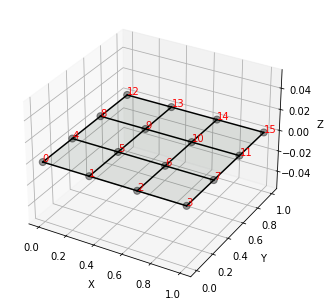

In [5]:
import ratatoskr_tools.networkplot as rtnplt

fig_network = rtnplt.plot_static("./example/network.xml", "./example/config.ini", plt_show=True)

## Simulation & Data handle

During the simulation, 3 kinds of data will be generated, which are VC usages, Buff usages and latencies (flit, packet, network). So, we need to give an initialization for each variable:

In [6]:
import numpy as np

# initialization of variables
vc_usages = []
buff_usages = []
inj_rates = np.arange(config.runRateMin, config.runRateMax, config.runRateStep).round(4)
lats_flit = -np.ones((len(inj_rates), config.restarts))
lats_packet = -np.ones((len(inj_rates), config.restarts))
lats_network = -np.ones((len(inj_rates), config.restarts))

Then, we can start the simulation and let's import the module for it:

In [7]:
import ratatoskr_tools.simulation as rtsim
import ratatoskr_tools.datahandle as rtdat

Before the simulation, it is recommended to clean the dummy directories to ensure that the directory is clean.

In [8]:
rtsim.remove_all_simdirs("./example/", config.restarts)

Then, we can start to simulate according to different injection rates. If you still haven't done the prerequisite (compile and retrieve the ./sim, please get it from the ratatoskr repository. Otherwise, you would not be able to continue this section).

Within the loop, we will first create the dummy simulation directories for repetitive simultion with same injection rate. (Here, the config.ini restarts default is 4 times).

Then, we run the simulation parallely to speed up the simulation.

After all simulations with same injection rate are completed, we can retrieve the simulation results which are stored in "simdirs".

At the end of each loop, the dummy simulation directories are removed to make sure the data in next cycle of loop will not overlapped. (Notes: You can make more dummy directories for different injection rates too, here is just given a simple workflow :D).

In [9]:
for idx, inj_rate in enumerate(inj_rates):

    simdirs = rtsim.make_all_simdirs("./example/", config.restarts)

    rtcfg.edit_config_file(config, "./example/config.xml", "./example/config_tmp.xml", inj_rate)

    rtsim.run_parallel_multiple_sims(simdirs, "./sim", "./example/config.xml", "./example/network.xml")

    vc_usages.append(rtdat.retrieve_vc_usages(simdirs))
    buff_usages.append(rtdat.retrieve_buff_usages(simdirs))
    lats_flit[idx], lats_network[idx], lats_packet[idx] = rtdat.retrieve_diff_latencies(simdirs)

    rtsim.remove_all_simdirs("./example/", config.restarts)

## Data plot

After all simulation results are retrieved, we can plot and see how the simulation is going on.

Here is the plotting for latencies:

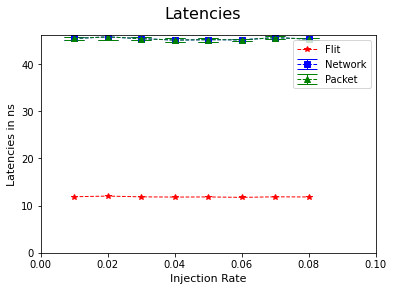

In [10]:
import ratatoskr_tools.dataplot as rtdplt

fig_latencies = rtdplt.plot_latencies(inj_rates, lats_flit, lats_network, lats_packet, plt_show=True)

The plotting for vc usages ans buff usages are a lot, so we will first store it in the list without showing it.

In [11]:
%matplotlib agg
figs_vc = rtdplt.plot_vc_usage_stats(vc_usages, inj_rates)
figs_buff = rtdplt.plot_buff_usage_stats(buff_usages, inj_rates)

## End

To output all plotted images, it is recommended to do it in the following way:

In [12]:
import os
from matplotlib.backends.backend_pdf import PdfPages

figs = [fig_network, fig_latencies]
figs.extend(figs_vc)
figs.extend(figs_buff)

pdf = PdfPages(os.path.join("./example/", "result.pdf"))
for fig in figs:
    pdf.savefig(fig)
pdf.close()